# XRD Soil Mineral ID - Interactive Notebook

   two_theta_1  intensity_1  two_theta_2  intensity_2  two_theta_3  \
0     2.003283        30529     2.003283        40265     2.003283   
1     2.009844        30314     2.009844        40025     2.009844   
2     2.016406        30211     2.016406        39948     2.016406   
3     2.022968        29951     2.022968        39389     2.022968   
4     2.029530        29733     2.029530        39564     2.029530   

   intensity_3  
0        59341  
1        59075  
2        58584  
3        58963  
4        58224  


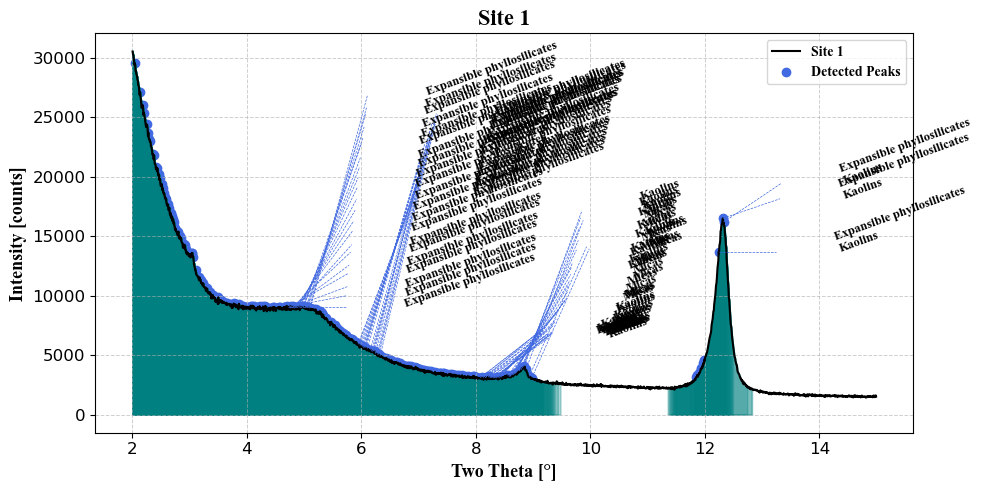


Percentage distribution of detected minerals for each sample:

                            Site 1
Expansible phyllosilicates   52.10
Kaolins                      32.24
Micas                        15.66


In [1]:
# Check for required packages
required_packages = ['numpy', 'pandas', 'matplotlib', 'scipy', 'openpyxl']
missing = []

for pkg in required_packages:
    try:
        __import__(pkg)
    except ImportError:
        missing.append(pkg)

if missing:
    print("\n❌ Missing required packages:")
    for pkg in missing:
        print(f" - {pkg}")
    print("\nTo install all required packages, run:")
    print("   pip install -r requirements.txt\n")
    exit(1)


# Import Modules 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import trapz
import matplotlib.cm as cm
from matplotlib import font_manager

# Determine path
try:
    # If run as a script
    base_dir = os.path.dirname(__file__)
except NameError:
    # If run in Notebook or interactive mode
    base_dir = os.getcwd()

# Path to the example Excel file in /data/
file_path = os.path.join(base_dir, 'data', 'soil_xrd_data_example.xlsx')

# Load data
df = pd.read_excel(file_path)

# Preview
print(df.head())

# --- 2θ Reference Peaks of Minerals --- 
soil_minerals_2theta = {
    'Amphiboles': [10.37, 27.34, 32.78, 10.52, 28.59, 32.78, 10.55, 28.59, 33.03],
    'Carbonate': [26.19, 45.79, 27.25, 29.46, 48.65, 23.08, 31.03, 41.19, 50.67],
    'Expansible phyllosilicates': [4.91, 9.82, 19.76, 6.13, 12.32, 18.51, 24.71],
    'Feldspars': [27.95, 22.04, 27.77, 27.86, 27.17, 21.98, 27.51, 27.08, 21.03,26.91, 23.58, 21.03],
    'Kaolins': [8.26, 8.84, 11.63, 20.17, 26.19, 12.33, 24.85],
    'Micas': [8.75, 26.43, 43.92, 8.84, 26.75, 17.72],
    'Oxides-Hydroxides': [25.35, 48.1, 37.77, 18.28, 20.31, 37.6, 21.24, 36.65, 33.15, 33.28, 34.6, 54.23, 32.66, 35.6, 53.21, 26.67, 20.84, 50.08, 27.34, 54.23, 36.04],
    'Phosphates': [31.94, 33.15, 32.29, 20.26, 16.1, 28.68, 20.69, 16.43, 18.35, 10.19, 10.5, 27.68],
}


## 
# Peak Detection # 
# --- Load data from XRD sample (or samples); it should include intensity and two_theta angle.----#

two_theta = np.array(df['two_theta_1'])
intensity = np.array(df['intensity_1'])
label = "Site 1" # Here replace with the sample name
color = "royalblue"  # Here adjust the color if you want a different shade

## Select Key Soil Minerals for XRD Peak Matching
## Define the list of target minerals commonly 
## found in soil to identify corresponding peaks in the XRD spectrum.
## Make sure that 'soil_minerals_2theta' is defined beforehand.

selected_minerals = [
    'Amphiboles', 'Carbonate', 'Expansible phyllosilicates',
    'Feldspars', 'Kaolins', 'Micas', 'Oxides-Hydroxides', 'Phosphates'
]

## Automatic Peak Detection in XRD Data

mean_intensity = np.mean(intensity)
std_intensity = np.std(intensity)
max_intensity = np.max(intensity)
thresholds = [mean_intensity, mean_intensity + std_intensity, 0.1 * max_intensity, 0.2 * max_intensity]

## Select Optimal Threshold for Reliable Peak Detection
## Iterate through predefined thresholds to identify a suitable one,
## that yields a manageable number of peaks (between 3 and 10). 
## If none meet the criteria, default to 10% of the maximum intensity.


for thresh in thresholds:
    peaks, _ = find_peaks(intensity, height=thresh)
    if 3 <= len(peaks) <= 10:
        best_threshold = thresh
        break
else:
    best_threshold = 0.1 * max_intensity
    peaks, _ = find_peaks(intensity, height=best_threshold)

## Plot XRD Spectrum with Detected Peaks
## Create the XRD plot by displaying the intensity versus 2θ values. 
## Overlay detected peaks using scatter points to highlight their positions.

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(two_theta, intensity, color='k', label=label)
ax.scatter(two_theta[peaks], intensity[peaks], color=color, marker='o', label='Detected Peaks')

## --- Highlight Peak Regions in XRD Plot ---
for peak in peaks:
    peak_pos = two_theta[peak]
    mask = (two_theta >= peak_pos - 0.5) & (two_theta <= peak_pos + 0.5)
    ax.fill_between(two_theta[mask], intensity[mask], alpha=0.3, color='teal')

## Label Minerals at Detected XRD Peaks

## For each detected peak, compare its 2θ position with reference values of selected minerals within a ±0.2° threshold. 
##Label matched minerals on the plot, adjusting vertically to avoid overlaps. 
## Format axes, labels, title, and legend for clarity and presentation, and display the final XRD spectrum with annotations.

threshold = 0.2
placed_labels = []

for peak in peaks:
    peak_x = two_theta[peak]
    peak_y = intensity[peak]

    matched_minerals = []
    for mineral, ref_peaks in soil_minerals_2theta.items():
        if mineral in selected_minerals:
            if any(abs(peak_x - ref) < threshold for ref in ref_peaks):
                matched_minerals.append(mineral)

    if matched_minerals:
        
# Position adjustment to avoid overlapping
        
        y_offset = 0
        for prev_x, prev_y in placed_labels:
            if abs(prev_x - peak_x) < 2.0:
                y_offset += 0.1 * peak_y
        final_y = peak_y + y_offset
        placed_labels.append((peak_x, final_y))

        ax.plot([peak_x, peak_x + 1], [peak_y, final_y], color=color, linestyle='--', linewidth=0.5)
        ax.text(peak_x + 2, final_y, "\n".join(matched_minerals), ha='left', rotation=20,
                fontsize=9, fontname="Times New Roman", fontweight="bold", color='k')

# --- Final plot adjustments ---

ax.set_ylabel('Intensity [counts]', fontsize=13, fontname="Times New Roman", fontweight="bold")
ax.set_xlabel('Two Theta [°]', fontsize=13, fontname="Times New Roman", fontweight="bold")
ax.set_title(label, fontsize=16, fontname="Times New Roman", fontweight="bold")
ax.grid(True, linestyle="--", linewidth=0.7, alpha=0.6)
ax.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

plt.tight_layout()
plt.show()


#1. Dictionary containing raw XRD data for one or more samples Each key corresponds to a site name (e.g., 'Site 1'), ## 
#and the value is a tuple of two arrays: ##
#diffraction angles (2θ) and corresponding intensities. The data can be displayed in tabular format for inspection or further analysis ##

sample_data = {
    
    'Site 1': (two_theta, intensity),
   
}



# -------------------------------
# 2.Detect minerals from actual peaks
# -------------------------------

def identify_minerals_from_peaks(two_theta, intensity, soil_minerals_2theta, threshold=0.2, height_factor=0.1):
    
    """
    Identifies minerals present in an XRD pattern by matching detected peaks with reference 2θ positions.

    Parameters:
    - two_theta (array-like): Array of diffraction angles (2θ).
    - intensity (array-like): Corresponding intensity values for each angle.
    - soil_minerals_2theta (dict): Dictionary where keys are mineral names and values are lists of known 2θ peak positions.
    - threshold (float, optional): Maximum allowed difference (in degrees 2θ) between a detected peak and a reference value to consider a match. Default is 0.2.
    - height_factor (float, optional): Minimum relative height (as a fraction of max intensity) required for a peak to be detected. Default is 0.1.

    Returns:
    - dict: Dictionary of identified minerals and their matched reference 2θ values.
    """
    height_thresh = np.max(intensity) * height_factor
    peaks, _ = find_peaks(intensity, height=height_thresh)
    peak_positions = two_theta[peaks]

    identified = {}
    for mineral, dspacings in soil_minerals_2theta.items():
        matched = []
        for ref in dspacings:
            if any(abs(peak - ref) < threshold for peak in peak_positions):
                matched.append(ref)
        if matched:
            identified[mineral] = matched
    return identified

# -------------------------------
# 3. Calculate the area under the detected peaks
# -------------------------------
def calculate_peak_area(two_theta, intensity, dspacings, window=0.5):
    """
    Calculates the total area under the peaks within specified windows around reference 2θ values.

    Parameters:
    - two_theta (array-like): Array of diffraction angles (2θ).
    - intensity (array-like): Corresponding intensity values.
    - dspacings (list or array-like): List of reference 2θ peak positions to integrate around.
    - window (float, optional): Half-width of the window around each reference peak for area calculation (in degrees 2θ). Default is 0.5.

    Returns:
    - float: Sum of the integrated peak areas within the specified windows.
    """
    area_sum = 0
    for ref in dspacings:
        mask = (two_theta >= ref - window) & (two_theta <= ref + window)
        area_sum += np.trapz(intensity[mask], two_theta[mask])
    return area_sum

# -------------------------------
# 4. Convert areas to percentages
# -------------------------------
def get_mineral_percentages(two_theta, intensity, identified_minerals):

    """
    Converts peak areas of identified minerals into percentage abundances.

    Parameters:
    - two_theta (array-like): Array of diffraction angles (2θ).
    - intensity (array-like): Corresponding intensity values.
    - identified_minerals (dict): Dictionary with mineral names as keys and lists of their reference 2θ peak positions as values.

    Returns:
    - dict: Mineral names as keys and their relative abundance percentages as values.
    """

    mineral_areas = {}
    for mineral, dspacings in identified_minerals.items():
        area = calculate_peak_area(two_theta, intensity, dspacings)
        mineral_areas[mineral] = area
    total = sum(mineral_areas.values())
    if total > 0:
        for mineral in mineral_areas:
            mineral_areas[mineral] = (mineral_areas[mineral] / total) * 100
    else:
        mineral_areas = {mineral: 0 for mineral in mineral_areas}
    return mineral_areas

# -------------------------------
# 4. Analysis by sample
# -------------------------------

def analyze_samples(sample_data, soil_minerals_2theta, threshold=0.2, height_factor=0.1):
    """
    Performs mineral identification and quantification for one sample or multiple samples.

    Parameters:
    - sites_data (dict): Dictionary with site names as keys and tuples of (two_theta, intensity) arrays as values.
    - soil_minerals_2theta (dict): Dictionary of reference minerals and their known 2θ peak positions.
    - threshold (float, optional): Maximum difference allowed for peak matching (default 0.2).
    - height_factor (float, optional): Relative intensity threshold for peak detection (default 0.1).

    Returns:
    - pandas.DataFrame: Table with mineral percentages for each site. Rows are minerals, columns are sites, sorted by average abundance.
    """
    results = {}
    for sample_name, (two_theta, intensity) in sample_data.items():
        identified = identify_minerals_from_peaks(two_theta, intensity, soil_minerals_2theta,
                                                  threshold=threshold, height_factor=height_factor)
        percentages = get_mineral_percentages(two_theta, intensity, identified)
        results[sample_name] = percentages
    df = pd.DataFrame(results).fillna(0)
    df['Average'] = df.mean(axis=1)
    df = df.sort_values(by='Average', ascending=False).drop(columns=['Average'])
    return df


# Run the analysis
df_percentages = analyze_samples(sample_data, soil_minerals_2theta)

# Display the resulting table
print("\nPercentage distribution of detected minerals for each sample:\n")
print(df_percentages.to_string(float_format="%.2f"))
